In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import time
# from torch.utils.tensorboard import SummaryWriter

Creating a dataframe with image url and label

In [2]:
def files_to_df(url,label):
    os.chdir(url)
    images_names = os.listdir()
    return pd.DataFrame(images_names,np.ones(len(images_names)) * label)

In [3]:
root_directory = os.getcwd()

In [4]:
paper_url = root_directory + '\\paper'
rock_url = root_directory + '\\rock'
scissors_url = root_directory + '\\scissors'

In [5]:
df_paper = files_to_df(paper_url,0)
df_rock = files_to_df(rock_url,1)
df_scissors = files_to_df(scissors_url,2)
df = pd.concat([df_paper,df_rock,df_scissors])

In [6]:
df['labels'] = df.index
df['labels'] = df['labels'].astype(int)
df.columns = ['images' , 'labels']
df

,images,labels
0.0,04l5I8TqdzF9WDMJ.png,0
0.0,0a3UtNzl5Ll3sq8K.png,0
0.0,0cb6cVL8pkfi4wF6.png,0
0.0,0eqArS2GgsBeqgSn.png,0
0.0,0Og76sl5CJhbxWWx.png,0
...,...,...
2.0,zV0yCNG0C9s4GId3.png,2
2.0,zyml8p6mHzWWJTyw.png,2
2.0,ZyZeKfG5s1J9Qn64.png,2
2.0,Zz1djgkAdRqsHM3z.png,2


Importing the data

In [7]:
class RockPaperScissors(Dataset):
    def __init__(self,directory,df,transform = None):
        self.transform = transform
        self.df = df
        self.directory = directory
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        img_url = os.path.join(self.directory , 'everything' ,self.df.iloc[index,0])
        img = np.asarray(Image.open(img_url))
        label = torch.tensor(int(self.df.iloc[index,1]))
        
        if self.transform:
            img = self.transform(img)
        return img , label
        

In [8]:
dataset = RockPaperScissors(root_directory,df,transform = transforms.ToTensor())

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
loader = DataLoader(dataset = dataset , batch_size = 8 , shuffle=True)

In [11]:
def get_mean_std(loader):
    channels_sum , channels_squared_sum , num_batches = 0,0,0
    for data,_ in loader:
        channels_sum += torch.mean(data,dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2,dim = [0,2,3])
        num_batches += 1
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean **2)**0.5
    return mean , std

In [12]:
mean , std = get_mean_std(loader)
print(f'mean = {mean}')
print (f'std = {std}')

C:\Users\amita\anaconda3\lib\site-packages\torchvision\transforms\functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


mean = tensor([0.3229, 0.5491, 0.2600])
std = tensor([0.2554, 0.1014, 0.1328])


In [13]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
dataset = RockPaperScissors(root_directory,df,transform = transforms.ToTensor())

train_split , val_split ,test_split = torch.utils.data.random_split(dataset,[1458,330,400])

train_loader = DataLoader(dataset = train_split , batch_size = 8 , shuffle=True)
val_loader = DataLoader(dataset = val_split , batch_size = 8 , shuffle=True)
test_loader = DataLoader(dataset = test_split , batch_size = 8 , shuffle=True)

In [14]:
criterion = nn.CrossEntropyLoss()

Training

In [15]:
def calc_acc(model,loader,lr,epoch,mode):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for x,y in loader:
                x , y = x.to(device) , y.to(device)
                y_hat = model(x)
                _ , pred = y_hat.max(1)
                correct += (pred == y).sum()
                total += pred.shape[0]
        print(f'{mode} score with learning rate {lr} , epoch {epoch + 1} = {correct/total}')
        model.train()
        return correct/total

In [16]:
os.chdir(root_directory)
start = time.perf_counter()
num_epochs = 20
lr = 1e-3
train_acc = []
val_acc = []

#Model
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features = 512 , out_features = 3)
model = model.to(device)
model.train()

#Optimizer
optimizer = torch.optim.Adam(model.fc.parameters(),lr = lr)

for epoch in range(num_epochs):
    for i, (x,y) in enumerate(train_loader):
        #Training the model
        x,y = x.to(device) , y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Training Accuracy
        _ , pred = y_hat.max(1)
        num_correct = (pred == y).sum()
        running_train_acc = float(num_correct)/float(x.shape[0])

    #Train Accuracy per epoch
    train_score = calc_acc(model,train_loader,lr,epoch , mode = 'training')
    train_acc.append(train_score)
    
    #Val Accuracy per epoch
    val_score = calc_acc(model,val_loader,lr,epoch,mode='val')
    val_acc.append(val_score)
    

    
end = time.perf_counter()

training score with learning rate 0.001 , epoch 1 = 0.9691358208656311
val score with learning rate 0.001 , epoch 1 = 0.9666666388511658
training score with learning rate 0.001 , epoch 2 = 0.9677640795707703
val score with learning rate 0.001 , epoch 2 = 0.9545454382896423
training score with learning rate 0.001 , epoch 3 = 0.9821673631668091
val score with learning rate 0.001 , epoch 3 = 0.9848484396934509
training score with learning rate 0.001 , epoch 4 = 0.9849108457565308
val score with learning rate 0.001 , epoch 4 = 0.9878787398338318
training score with learning rate 0.001 , epoch 5 = 0.9780521392822266
val score with learning rate 0.001 , epoch 5 = 0.9818181395530701
training score with learning rate 0.001 , epoch 6 = 0.9883401989936829
val score with learning rate 0.001 , epoch 6 = 0.9848484396934509
training score with learning rate 0.001 , epoch 7 = 0.991769552230835
val score with learning rate 0.001 , epoch 7 = 0.9909090399742126
training score with learning rate 0.001 , 

In [17]:
print(f'Training time = {end-start}')

Training time = 3193.3775843000003


Text(0, 0.5, 'Accuracy')

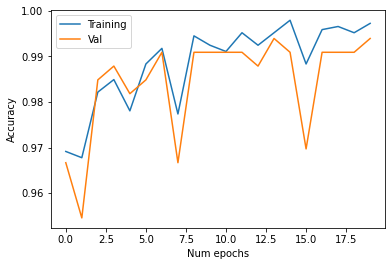

In [18]:
plt.plot(train_acc,label = 'Training')
plt.plot(val_acc, label = 'Val')
plt.legend()
plt.xlabel('Num epochs')
plt.ylabel('Accuracy')

Testing

In [19]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for x,y in test_loader:
            x , y = x.to(device) , y.to(device)
            y_hat = model(x)
            _ , pred = y_hat.max(1)
            correct += (pred == y).sum()
            total += pred.shape[0]
    print(f'model score = {correct/total}')
    model.train()

model score = 0.9975000023841858
